In [1]:
import pandas as pd
import numpy as np
import os
import math
import random
import matplotlib.pyplot as plt

In [2]:
import plotly.graph_objects as go
from plotly.offline import iplot

In [3]:
from sklearn.metrics import precision_score, recall_score, roc_curve

## Imports

In [4]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [5]:
import spacy
from spacy.tokens import Doc
from spacy.util import minibatch

In [6]:
from spacy.training import Example

In [7]:
def split_examples_to_batches(examples, batch_size):
    batches=[]
    for i in range(0, math.ceil(len(examples)/batch_size)):
        start=i*batch_size
        end = start+batch_size
        batches.append(examples[start:end])
    return batches

## Prepare data

In [72]:
# Read SPAM_classifier.csv with correct header handling
data = pd.read_csv("../data/SPAM_classifier.csv", header = 0,names = ["category", "text"])

In [73]:
data.drop_duplicates(inplace=True)
data["text_len"] = data.text.apply(lambda x: len(str(x)))
data = data.query("text_len<2000")
data = data.sample(5000)
data.reset_index(inplace=True, drop=True)
data.rename(columns = {"Category":"category", "Message":"text"}, inplace=True)

In [74]:
data

,category,text,text_len
0,ham,Ok lor wat time ü finish?,25
1,ham,cool. We will have fun practicing making babies!,48
2,spam,"Text82228>> Get more ringtones, logos and game...",101
3,ham,Cramps stopped. Going back to sleep,35
4,ham,Wewa is 130. Iriver 255. All 128 mb.,36
...,...,...,...
4995,ham,Wake me up at &lt;#&gt; am morning:),38
4996,ham,Is ur changes 2 da report big? Cos i've alread...,82
4997,spam,Double your mins & txts on Orange or 1/2 price...,160
4998,ham,Dai &lt;#&gt; naal eruku.,27


In [75]:
# create empty model and add labels
nlp = spacy.blank("en")
textcat = nlp.add_pipe("textcat")

for cat in ["ham", "spam"]:
    textcat.add_label(cat)

In [76]:
nlp.get_pipe("textcat").labels

('ham', 'spam')

In [77]:
nlp.get_pipe("textcat").labels

('ham', 'spam')

In [78]:
from sklearn.model_selection import train_test_split
texts_train, texts_test, labels_train, labels_test = train_test_split(data['text'], data['category'], test_size=0.2, random_state = 7)

In [79]:
texts_train.reset_index(inplace=True, drop=True)
labels_train.reset_index(inplace=True, drop=True)

texts_test.reset_index(inplace=True, drop=True)
labels_test.reset_index(inplace=True, drop=True)

## Transform data to texcat exammples

Create a function to iterate through texts and labels and convert them to spacy format

Spacy textcat format:
- example = Example.from_dict(nlp.make_doc(text), cat_label )
- cat_label format: {'cats': {'ham': True, 'spam': False}}

In [80]:
def prepare_textcat_examples(texts, labels):
    examples = []
    texts.reset_index(inplace=True, drop=True)
    labels.reset_index(inplace=True, drop=True)
    categories = list(labels.unique())
    for i in range(0, len(texts)):
        text = texts[i]
        label = labels[i]
        cat_label = {'cats': {category:label==category for category in categories}}
        example = Example.from_dict(nlp.make_doc(text), cat_label )
        examples.append(example)
    
    return examples

In [81]:
examples_train = prepare_textcat_examples(texts_train, labels_train)
examples_test = prepare_textcat_examples(texts_test, labels_test)

## Train models

In [82]:
def train_model(model, examples_train, examples_test, optimizer, batch_size, epochs=10):
    losses = {}
    random.seed(1)

    for epoch in range(epochs):
        random.shuffle(examples_train)

        batches = split_examples_to_batches(examples_train,batch_size)
        
        for batch in batches:
            
            model.update(batch, sgd=optimizer, losses=losses)
        score = model.evaluate(examples_test)
        print(f"Epoch {epoch}, score: {score['cats_score']}")


    return score 

In [83]:
def predict_label(text, nlp):
    doc = nlp(text)
    df_proba = pd.DataFrame.from_dict(doc.cats, orient = "index", columns = ["proba"])\
    .sort_values(by="proba", ascending=False)
    
    label = df_proba.index[:3]
    proba = df_proba.proba[:3]
    
    return  round(proba,2)

In [84]:
optimizer = nlp.begin_training()
batch_size = 20
epochs = 10

# Training the model
score  = train_model(nlp, examples_train, examples_test, optimizer, batch_size, epochs)

Epoch 0, score: 0.9469129903912512
Epoch 1, score: 0.9550253324703413
Epoch 2, score: 0.9471103353960303
Epoch 3, score: 0.956382438776805
Epoch 4, score: 0.9450807617908553
Epoch 5, score: 0.9547777325555104
Epoch 6, score: 0.9490196078431372
Epoch 7, score: 0.954526672083924
Epoch 8, score: 0.954526672083924
Epoch 9, score: 0.954526672083924


## Evaluate test set performance

### Confusion matrix

Get predictions and convert them to spam probability, y_hat and y_true

In [85]:
def get_predictions(texts, textcat):
    docs = [nlp(text) for text in texts]
    predictions = textcat.predict(docs)
    
    df_pred = pd.DataFrame(predictions.argmax(axis=1), columns = ["category_idx"])
    df_pred["spam_proba"] = predictions[:,1]
    df_pred["label_hat"] = df_pred.category_idx.apply(lambda x:textcat.labels[x])
    df_pred["label_true"] = labels_test
    
    return df_pred

In [86]:
df_pred = get_predictions(texts_test, textcat)

In [87]:
from sklearn.metrics import confusion_matrix

Get confusion matrix leveraging sklearn function

In [88]:
cf_matrix = confusion_matrix(df_pred["label_true"], df_pred["label_hat"])

<AxesSubplot: >

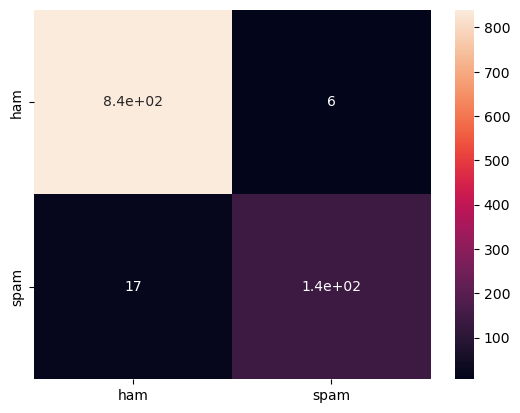

In [89]:
categories = textcat.labels
import seaborn as sns
sns.heatmap(cf_matrix, annot=True,  xticklabels=categories,
                yticklabels=categories)

### Recall and Precision

In [90]:
threshold = 0.5

Add spam hat label based on decision threshold

In [91]:
df_pred["is_spam_hat"] = np.where(df_pred.spam_proba>=threshold,1,0)

In [92]:
df_pred["is_spam_hat"].mean()

0.143

In [93]:
df_pred

,category_idx,spam_proba,label_hat,label_true,is_spam_hat
0,0,0.000004,ham,ham,0
1,0,0.000009,ham,ham,0
2,0,0.008195,ham,ham,0
3,0,0.000002,ham,ham,0
4,1,0.999990,spam,spam,1
...,...,...,...,...,...
995,0,0.000006,ham,ham,0
996,0,0.000002,ham,ham,0
997,0,0.000041,ham,ham,0
998,0,0.000052,ham,ham,0


In [94]:
df_pred["is_spam_true"] = np.where(df_pred.label_true == "spam",1,0)

Calculate precision and recall

In [95]:
precision_score(df_pred.is_spam_true, df_pred.is_spam_hat)

0.958041958041958

In [96]:
recall_score(df_pred.is_spam_true, df_pred.is_spam_hat)

0.8896103896103896

In [97]:
threshold

0.5

Create a function, which calculates recall and precision for threshold in range of 0-0.99

In [98]:
def metrics_by_threshold(df_pred):
    metrics = []
    for i in range(0,100):
        threshold = i/100
        #Calculate spam_hat based on threshold
        df_pred["is_spam_hat"] = np.where(df_pred.spam_proba>=threshold,1,0)
        recall = recall_score(df_pred.is_spam_true, df_pred.is_spam_hat)
        precision = precision_score(df_pred.is_spam_true, df_pred.is_spam_hat)
        
        #Create a list of dicts in format easily convertible to df
        metrics.append({"threshold":threshold,
                       "recall":recall,
                       "precision":precision})
        
    return pd.DataFrame(metrics)

In [99]:
df_scores = metrics_by_threshold(df_pred)

In [108]:

trace1=go.Scatter(
                x=df_scores.threshold,
                y=df_scores.precision,
                mode='lines',
                marker=dict(
                size=5
                ),
            name="precision",

            )


trace2=go.Scatter(
                x=df_scores.threshold,
                y=df_scores.recall,
                mode='lines',
                marker=dict(
                size=5
                ),
            name="recall",

            )
data = [trace1, trace2]
    
figure=go.Figure(
    data=data,
    layout=go.Layout(
        title=f"<b>Precision and Recall by threshold",
    
    ))
iplot(figure)

### ROC curve

Find mos convenient way to calculate fpr and tpr needed to create ROC curve

In [101]:
fpr, tpr, thresholds = roc_curve(df_pred.is_spam_true, df_pred.spam_proba)

In [102]:

trace1=go.Scatter(
                x=fpr,
                y=tpr,
                mode='lines',
                marker=dict(
                size=5
                ),
            name="precision",

            )

data = [trace1]
    
figure=go.Figure(
    data=data,
    layout=go.Layout(
        title=f"<b>ROC curve",
        xaxis={"title":"False positives rate"},
        yaxis={"title":"True positives rate"}
    ))
iplot(figure)

## Business value based approach to recall and precision

False positives and False negatives costs loss in ads revenue displayed on email
- Allowing a SPAM email to land in inbox costs 1 USD 
- Classyfing actual email as SPAM costs 2 USD

In [103]:
def calculate_business_costs(df_scores, FP_cost, FN_cost):
    df_scores["costs"] = df_scores.FP*FP_cost + df_scores.FN*FN_cost
    
    return df_scores
    
    
    


In [104]:
def metrics_by_threshold(df_pred):
    metrics = []
    for i in range(0,100):
        threshold = i/100
        df_pred["is_spam_hat"] = np.where(df_pred.spam_proba>=threshold,1,0)
        recall = recall_score(df_pred.is_spam_true, df_pred.is_spam_hat)
        precision = precision_score(df_pred.is_spam_true, df_pred.is_spam_hat)
        conf = confusion_matrix(df_pred.is_spam_true, df_pred.is_spam_hat)
        FP  = conf[0,1]
        FN = conf[1,0]
        
        metrics.append({"threshold":threshold,
                       "recall":recall,
                       "precision":precision, 
                       "FP":FP, 
                       "FN":FN})
        
    return pd.DataFrame(metrics)

In [105]:
df_scores = metrics_by_threshold(df_pred)

In [106]:
df_scores = calculate_business_costs(df_scores, 2, 1)

In [107]:
df_scores.sort_values(by="costs")

,threshold,recall,precision,FP,FN,costs
84,0.84,0.883117,0.978417,3,18,24
80,0.80,0.883117,0.978417,3,18,24
81,0.81,0.883117,0.978417,3,18,24
82,0.82,0.883117,0.978417,3,18,24
83,0.83,0.883117,0.978417,3,18,24
...,...,...,...,...,...,...
4,0.04,0.896104,0.926174,11,16,38
3,0.03,0.896104,0.926174,11,16,38
2,0.02,0.896104,0.926174,11,16,38
1,0.01,0.896104,0.920000,12,16,40
